In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.cross_validation import cross_val_score, cross_val_predict, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('white')
sns.set_context('talk')

# Feature Engineering

In [4]:
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return None

def get_cabin_deck(cabin):
    if cabin.isnan():
        return None
    deck_search = re.search(' ([A-Z])', cabin)
    if deck_search:
        return deck_search.group(1)
    
def get_cabin_number(cabin):
    number_search = re.search(' ([0-9]+)', cabin)
    if number_search:
        return number_search.group(1)

In [5]:
sex_map = {
        'male': 0,
        'female': 1
    }

embarked_map = {
    'S': 0,
    'C': 1,
    'Q': 2
}

title_map = {
    'Mr': 1,
    'Miss': 2,
    'Mrs': 3,
    'Master': 4,
    'Dr': 5,
    'Rev': 6,
    'Major': 7,
    'Col': 7,
    'Mlle': 8,
    'Mme': 8,
    'Don': 9,
    'Lady': 10,
    'Countess': 10,
    'Jonkheer': 10,
    'Sir': 9,
    'Capt': 7,
    'Ms': 2
}



In [6]:
def process_dataset(df):
    
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Embarked'] = df['Embarked'].fillna('S')
    df['Sex'] = df['Sex'].map(sex_map)
    df['Embarked'] = df['Embarked'].map(embarked_map)
    df['FamilySize'] = df['SibSp'] + df['Parch']
    df['NameLength'] = df['Name'].apply(lambda x: len(x))
    df['Title'] = df['Name'].apply(get_title).map(title_map)
    df['Title'] = df['Title'].fillna(0)
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
#     df['Cabin'] = df['Cabin'].fillna('')
#     df['CabinDeck'] = df['Cabin'].apply(get_cabin_deck)
#     df['CabinNumber'] = df['Cabin'].apply(get_cabin_number)
    
    return df

In [7]:
titanic = pd.read_csv('data/train.csv')
titanic = process_dataset(titanic)

titanic.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,NameLength,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,1,23,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,1,51,3
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,22,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,1,44,3
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,0,24,1


In [8]:
titanic['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31',
       'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47',
       'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4',
       'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77',
       'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D',
       'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7',
       'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37',
       'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104', 'C111',
       'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30', 'D20',
       'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22', 'C86',
       'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19',
       'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126', 'B71',
       'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64', 'E24',

# Feature Selection

In [9]:
# Select all columns which contain ints or floats
potential_features = titanic.select_dtypes(include=['int','float']).columns.tolist()

# Remove target column. Obviously it would perfectly correlate and must be excluded.
potential_features.remove('Survived')

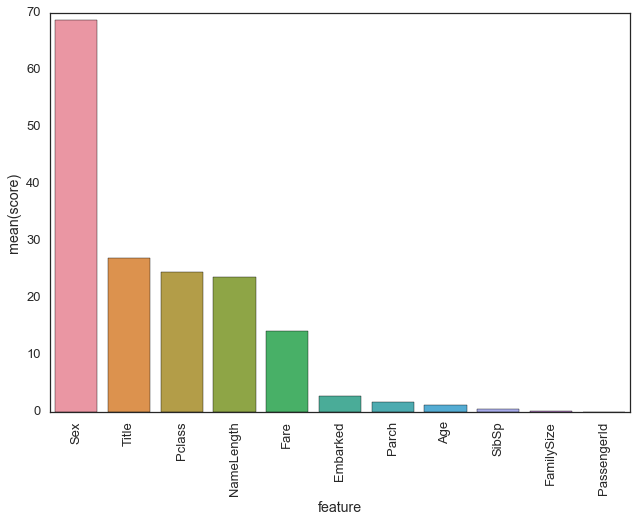

In [10]:
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[potential_features], titanic['Survived'])

scores = -np.log10(selector.pvalues_)

data = {
    'feature': potential_features,
    'score': scores
}

feature_fit = pd.DataFrame(data=data)
feature_fit.sort_values('score', inplace=True, ascending=False)

sns.barplot(x='feature',y='score',data=feature_fit)
plt.xticks(rotation='vertical')
plt.show()

In [11]:
# Based on above chart, let's use features that scored above 10
min_score = 10
predictors = feature_fit[feature_fit['score'] > min_score]['feature'].values.tolist()
predictors

['Sex', 'Title', 'Pclass', 'NameLength', 'Fare']

In [12]:
# Full set of predictors
# predictors = ['Sex', 'Title', 'Pclass', 'NameLength', 'Fare', 'Age', 'SibSp', 'Parch', 'Embarked', 'FamilySize']

# Algorithms

In [13]:
algorithms = []

# Add Random Forest
algorithms.append([RandomForestClassifier(n_estimators=150, min_samples_split=8, min_samples_leaf=4), predictors, 3])

# Add Logistic Regression
algorithms.append([LogisticRegression(), predictors, 1])

# Fit Model and Make Predictions

In [14]:
print('Calculate quadrant metrics. TPR, FPR, etc, etc')

Calculate quadrant metrics. TPR, FPR, etc, etc


In [15]:
# def check_performance4(algorithms, train):

print('Add column and save num predictors run for each algorithm into results. Then work on aggregation to get back the current results and avg_results dataframes')


Add column and save num predictors run for each algorithm into results. Then work on aggregation to get back the current results and avg_results dataframes


In [16]:
def check_performance3(algorithms, train):

    kf = KFold(train.shape[0], n_folds=10)
    fold_numbers = list(range(1,kf.n_folds+1))

    results = pd.DataFrame()
    avg_results = pd.DataFrame()

    for alg, predictors, weight in algorithms:

        alg_name = type(alg).__name__
        
        for i, predictor in enumerate(predictors):
            
            features = train[predictors[0:i+1]]
            target = train['Survived']
            
            predictions = cross_val_predict(alg, features, target, cv=kf)
            scores = cross_val_score(alg, features, target, cv=kf)
            mses = mean_squared_error(y_true=target, y_pred=predictions)
            variances = np.var(predictions)

            cv_results = pd.DataFrame()
            cv_results['algorithm'] = alg_name
            cv_results['num_features'] = i+1
            cv_results['avg_score'] = np.mean(scores)
            cv_results['avg_mse'] = np.mean(mses)
            cv_results['avg_variance'] = np.mean(variances)
            
            print(cv_results)
            
            avg_results = avg_results.append(cv_results, ignore_index=True)
            print(avg_results)
        

        alg_results = pd.DataFrame()
        alg_results['algorithm'] = [alg_name] * kf.n_folds
        alg_results['fold'] = fold_numbers
        alg_results['score'] = scores
        alg_results['mse'] = mses
        alg_results['variance'] = variances

        results = results.append(alg_results, ignore_index=True)
    
    print(results)
    print(avg_results)
    plot_scores(results)
    plot_metrics(avg_results)
    
    return results

In [17]:
# Store all metrics in results and aggregate when needed?

In [18]:
def plot_scores(df):
    bins = np.linspace(.5,1,11)

    g = sns.FacetGrid(df, col='algorithm', size=6, aspect=1)
    g.map(sns.distplot,'score', kde=False, bins=bins)
    plt.xticks(bins)
    plt.xlim((np.min(bins), np.max(bins)))
    plt.show()

In [19]:
def plot_metrics(df):
    pointfive_one = np.linspace(.5, 1, 11)
    zero_pointfive = np.linspace(0, .5, 11)

    g = sns.FacetGrid(df, col='algorithm', size=6, aspect=1)
    g.map(sns.regplot,'num_features','avg_score', fit_reg=True)
    plt.yticks(pointfive_one)
    plt.ylim((np.min(pointfive_one), np.max(pointfive_one)))
    
    g = sns.FacetGrid(df, col='algorithm', size=6, aspect=1)
    g.map(sns.regplot,'num_features','avg_mse', color='red', label='Average MSE', fit_reg=True, ci=False)
    g.map(sns.regplot,'num_features','avg_variance', color='blue', label='Average Variance', fit_reg=True, ci=False).add_legend()
    plt.yticks(zero_pointfive)
    plt.ylim((np.min(zero_pointfive), np.max(zero_pointfive)))
    
    plt.show()
    
    # Combine plot defs?

Empty DataFrame
Columns: [algorithm, num_features, avg_score, avg_mse, avg_variance]
Index: []
Empty DataFrame
Columns: [algorithm, num_features, avg_score, avg_mse, avg_variance]
Index: []
Empty DataFrame
Columns: [algorithm, num_features, avg_score, avg_mse, avg_variance]
Index: []
Empty DataFrame
Columns: [algorithm, num_features, avg_score, avg_mse, avg_variance]
Index: []
Empty DataFrame
Columns: [algorithm, num_features, avg_score, avg_mse, avg_variance]
Index: []
Empty DataFrame
Columns: [algorithm, num_features, avg_score, avg_mse, avg_variance]
Index: []
Empty DataFrame
Columns: [algorithm, num_features, avg_score, avg_mse, avg_variance]
Index: []
Empty DataFrame
Columns: [algorithm, num_features, avg_score, avg_mse, avg_variance]
Index: []
Empty DataFrame
Columns: [algorithm, num_features, avg_score, avg_mse, avg_variance]
Index: []
Empty DataFrame
Columns: [algorithm, num_features, avg_score, avg_mse, avg_variance]
Index: []
Empty DataFrame
Columns: [algorithm, num_features,

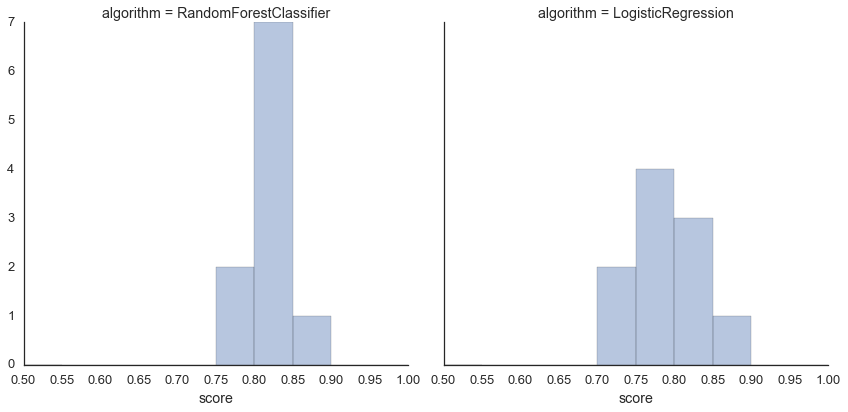

IndexError: index out of range

In [20]:
results = check_performance3(algorithms, titanic)

In [ ]:
def check_performance2(algorithms, train):

    kf = KFold(train.shape[0], n_folds=10)
    fold_numbers = list(range(1,kf.n_folds+1))

    results = pd.DataFrame()

    for alg, predictors, weight in algorithms:
        
        features = train[predictors]
        target = train['Survived']
        
        predictions = cross_val_predict(alg, features, target, cv=kf)
        scores = cross_val_score(alg, features, target, cv=kf)
        
        mses = mean_squared_error(y_true=target, y_pred=predictions)
        variances = np.var(predictions)
        
        alg_name = type(alg).__name__

        alg_results = pd.DataFrame()
        alg_results['algorithm'] = [alg_name] * kf.n_folds
        alg_results['fold'] = fold_numbers
        alg_results['score'] = scores
        alg_results['mse'] = mses
        alg_results['variance'] = variances

        results = results.append(alg_results, ignore_index=True)
        
        print('**************************************************')
        print(alg_name)
        print('Number of Folds: {}'.format(kf.n_folds))
        print('Accuracy: {:.2} (+/- {:.2})'.format(np.mean(scores), np.std(scores) * 2))
        print('Average MSE: {:.2} (+/- {:.2})'.format(np.mean(mses), np.std(mses) * 2))
        print('Average Variance: {:.2} (+/- {:.2})'.format(np.mean(variances), np.std(variances) * 2))
        print('**************************************************\n')
        
    plot_scores(results)
    
    return results

In [ ]:
results = check_performance2(algorithms, titanic)

In [ ]:
def fold_it(alg, predictors, train, kf=None):
    
    if kf == None:
        kf = KFold(train.shape[0], n_folds=3)

    scores = []
    mses = []
    variances = []
    
    for train_index, test_index in kf:

            features_train = train[predictors].iloc[train_index]
            target_train = train['Survived'].iloc[train_index]
            features_test = train[predictors].iloc[test_index]
            target_test = train['Survived'].iloc[test_index]

            # Fit model to training set
            alg.fit(features_train, target_train)

            # Predict on test set
            prediction = alg.predict(features_test)

            # Collect accuracy metrics
            score = alg.score(features_test, target_test)
            mse = mean_squared_error(y_true=target_test, y_pred=prediction)
            variance = np.var(prediction)

            # Append to lists
            scores.append(score)
            mses.append(mse)
            variances.append(variance)
    
    return [scores, mses, variances]

In [ ]:
def check_performance(algorithms, train, kf = None):

    kf = KFold(train.shape[0], n_folds=10)
    fold_numbers = list(range(1,kf.n_folds+1))

    results = pd.DataFrame()

    for alg, predictors, weight in algorithms:

        if kf:
            scores, mses, variances = fold_it(alg, predictors, train, kf=kf)
        
        alg_name = type(alg).__name__

        print('**************************************************')
        print(alg_name)
        print('Number of Folds: {}'.format(kf.n_folds))
        print('Accuracy: {:.2} (+/- {:.2})'.format(np.mean(scores), np.std(scores) * 2))
        print('Average MSE: {:.2} (+/- {:.2})'.format(np.mean(mses), np.std(mses) * 2))
        print('Average Variance: {:.2} (+/- {:.2})'.format(np.mean(variances), np.std(variances) * 2))
        print('**************************************************\n')

        alg_results = pd.DataFrame()
        alg_results['algorithm'] = [alg_name] * kf.n_folds
        alg_results['fold'] = fold_numbers
        alg_results['score'] = scores
        alg_results['mse'] = mses
        alg_results['variance'] = variances

        results = results.append(alg_results, ignore_index=True)
        
    plot_scores(results)
    
    return results

In [ ]:
results = check_performance(algorithms, titanic)

In [ ]:
def fit_train_set(train):
    kf = KFold(train.shape[0], n_folds=10)
    fold_numbers = list(range(1,kf.n_folds+1))

    all_predictions = []
    all_probabilities = []
    
    total_weight = 0
    for row in algorithms:
        total_weight += row[2]

    results = pd.DataFrame()

    for alg, predictors, weight in algorithms:
        
        weight_ratio = weight/total_weight

        alg_results = pd.DataFrame()

        alg_name = type(alg).__name__
        predictions = []
        probabilities = []
        scores = []
        mses = []
        variances = []

        for train_index, test_index in kf:

            features_train = train[predictors].iloc[train_index]
            target_train = train['Survived'].iloc[train_index]
            features_test = train[predictors].iloc[test_index]
            target_test = train['Survived'].iloc[test_index]

            # Fit model to training set
            alg.fit(features_train, target_train)

            # Predict on test set
            prediction = alg.predict(features_test)
            probability = alg.predict_proba(features_test)

            # Collect accuracy metrics
            score = alg.score(features_test, target_test)
            mse = mean_squared_error(y_true=target_test, y_pred=prediction)
            variance = np.var(prediction)

            # Append to lists
            predictions.append(prediction)
            probabilities.append(probability[:,1])
            scores.append(score)
            mses.append(mse)
            variances.append(variance)

        print('**************************************************')
        print(alg_name)
        print('Number of Folds: {}'.format(kf.n_folds))
        print('Accuracy: {:.2} (+/- {:.2})'.format(np.mean(scores), np.std(scores) * 2))
        print('Average MSE: {:.2} (+/- {:.2})'.format(np.mean(mses), np.std(mses) * 2))
        print('Average Variance: {:.2} (+/- {:.2})'.format(np.mean(variances), np.std(variances) * 2))
        print('**************************************************\n')

        # Put all predictions and probabilities into one list
        all_predictions.append(np.concatenate(predictions, axis=0))
        all_probabilities.append(np.concatenate(probabilities, axis=0) * weight_ratio)

        alg_results['algorithm'] = [alg_name] * kf.n_folds
        alg_results['weight'] = [weight_ratio] * kf.n_folds
        alg_results['fold'] = fold_numbers
        alg_results['score'] = scores
        alg_results['mse'] = mses
        alg_results['variance'] = variances

        results = results.append(alg_results, ignore_index=True)

    weighted_predictions = np.array(all_probabilities).T.sum(axis=1)
    weighted_predictions[weighted_predictions > .5] = 1
    weighted_predictions[weighted_predictions <= .5] = 0

    weighted_predictions = weighted_predictions.astype(int)
    
    return results

In [ ]:
def fit_test_set(train, test):

    all_predictions = []    
    total_weight = 0

    for row in algorithms:
        total_weight += row[2]

    for alg, predictors, weight in algorithms:
        
        # Fit model to training set
        alg.fit(train[predictors], train['Survived'])

        # Predict on test set
        predictions = alg.predict_proba(test[predictors])
        
        weight_ratio = weight/total_weight
        all_predictions.append(predictions[:,1] * weight_ratio)
    
    weighted_predictions = np.array(all_predictions).T.sum(axis=1)
    weighted_predictions[weighted_predictions > .5] = 1
    weighted_predictions[weighted_predictions <= .5] = 0

    weighted_predictions = weighted_predictions.astype(int)
    
    return weighted_predictions

In [ ]:
results = fit_train_set(titanic)
plot_scores(results)

Possibly use cross_val above to automatically do cross-validation. Problem is there is no cross_val_predict_proba. There is apparently a fix to address this in work which uses cross_val_predict(method='predict_proba'), but it is not in the released version yet.

In [ ]:
#     cross_predictions = cross_val_predict(alg, titanic[predictors], titanic['Survived'], cv=10)
#     cross_score = cross_val_score(alg, titanic[predictors], titanic['Survived'], cv=10)

Combine prediction probabilities using weight for each algorithm.

If more algorithms, maybe use majority vote?

# Check For Overfitting

!!!fix to call other functions and use algorithms!!!

In [ ]:
avg_mse = []
avg_variance = []

for index, predictor in enumerate(predictors):
    features = titanic[predictors[0:index+1]]
    target = titanic['Survived']
    
    alg = algorithms[0][0]

    predictions = cross_val_predict(alg, features, target, cv=5)
    
    mse = mean_squared_error(y_true=target, y_pred=predictions)
    variance = np.var(predictions)
    
    avg_mse.append(np.mean(mse))
    avg_variance.append(np.mean(variance))

In [ ]:
plt.scatter(range(0,len(avg_mse)), y=avg_mse, c='r')
plt.scatter(range(0,len(avg_variance)), y=avg_variance, c='b')
plt.show()

# Fit Test Set

In [ ]:
titanic_test = pd.read_csv('data/test.csv')
titanic_test = process_dataset(titanic_test)

predictions = fit_test_set(titanic, titanic_test)

In [ ]:
def check_submission_rules(df):
    assert df.shape[0] == 418

check_submission_rules(predictions)

submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

submission.to_csv('submissions/improving_your_submission.csv', index=False)